In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Define the Winner Take All units
class WTU(object):
    
    #_learned = False
    
    def __init__(self, m, n, dim, num_iterations, eta = 0.5, sigma = None):
        """
        m x n : The dimension of 2D lattice in which neurons are arranged
        dim : Dimension of input training data
        num_iterations: Total number of training iterations
        eta : Learning rate
        sigma: The radius of neighbourhood function.
        """
        self._m = m
        self._n = n
        self._neighbourhood = []
        self._topography = []
        self._num_iterations = int(num_iterations) 
        self._learned = False
        
        eta = float(eta)
           
        if sigma is None:
            sigma = max(m,n)/2.0    # Constant radius
        else:
            sigma = float(sigma)
        
            
        print('Network created with dimensions',m,n)
            
        self._graph = tf.Graph()
        
        # Build Computation Graph of SOM
        
        with self._graph.as_default():
            # Weight Matrix and the topography of neurons
            self._W = tf.Variable(tf.random_normal([m*n, dim], seed = 0))
            self._topography = tf.constant(np.array(list(self._neuron_location(m, n))))
            
            # Placeholders for training data
            self._X = tf.placeholder('float', [dim])
            
            # Placeholder to keep track of number of iterations
            self._iter = tf.placeholder('float')
            
            # Finding the Winner and its location
            d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([self._X 
                                                for i in range(m*n)]),2),1))
            self.WTU_idx = tf.argmin(d,0)
            
            slice_start = tf.pad(tf.reshape(self.WTU_idx, [1]),np.array([[0,1]]))
            self.WTU_loc = tf.reshape(tf.slice(self._topography, slice_start,[1,2]), [2])
            
            
            # Change learning rate and radius as a function of iterations
            learning_rate = 1 - self._iter/self._num_iterations
            _eta_new = eta * learning_rate
            _sigma_new = sigma * learning_rate
            
            
            # Calculating Neighbourhood function
            distance_square = tf.reduce_sum(tf.pow(tf.subtract(
                self._topography, tf.stack([self.WTU_loc for i in range(m * n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                distance_square, "float32"), tf.pow(_sigma_new, 2))))
            
            # multiply learning rate with neighbourhood func
            eta_into_Gamma = tf.multiply(_eta_new, neighbourhood_func)
            
            # Shape it so that it can be multiplied to calculate dW
            weight_multiplier = tf.stack([tf.tile(tf.slice(
                eta_into_Gamma, np.array([i]), np.array([1])), [dim])
                for i in range(m * n)])
            delta_W = tf.multiply(weight_multiplier,
                tf.subtract(tf.stack([self._X for i in range(m * n)]),self._W))
            new_W = self._W + delta_W
            self._training = tf.assign(self._W,new_W)
            
            # Initialize All variables
            init = tf.global_variables_initializer()
            
            self._sess = tf.Session()
            self._sess.run(init)
            
    def fit(self, X):
        """
        Function to carry out training
        """
        for i in range(self._num_iterations):
            for x in X:
                self._sess.run(self._training, feed_dict= {self._X:x, self._iter: i})
            
        
        
        # Store a centroid grid for easy retreival
        centroid_grid = [[] for i in range(self._m)]
        self._Wts = list(self._sess.run(self._W))
        self._locations = list(self._sess.run(self._topography))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._Wts[i])
        self._centroid_grid = centroid_grid

        self._learned = True
    
    def winner(self, x):
        idx = self._sess.run([self.WTU_idx,self.WTU_loc], feed_dict = {self._X:x})
        return idx
             
    def _neuron_location(self,m,n):
        """
        Function to generate the 2D lattice of neurons
        """
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])
                
                
    def get_centroids(self):
        """
        Function to return a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._learned:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid

    def map_vects(self, X):
        """
        Function to map each input vector to the relevant neuron in the lattice
        """

        if not self._learned:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))],
                            key=lambda x: np.linalg.norm(vect -
                                                         self._Wts[x]))
            to_return.append(self._locations[min_index])

        return to_return


            
        


In [4]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [5]:
## Reading input data from file
import pandas as pd

df = pd.read_csv('colors.csv')  # The last column of data file is a label
data = normalize(df[['R', 'G', 'B']]).values
name = df['Color-Name'].values
n_dim = len(df.columns) - 1


In [6]:
# Data for Training
colors = data
color_names = name

Network created with dimensions 30 30


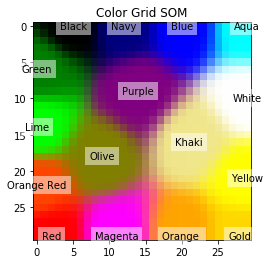

In [7]:
som = WTU(30, 30, n_dim, 400, sigma=10.0)
som.fit(colors)

# Get output grid
image_grid = som.get_centroids()

# Map colours to their closest neurons
mapped = som.map_vects(colors)

# Plot
plt.imshow(image_grid)
plt.title('Color Grid SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))


In [8]:
idx, loc = som.winner([0.5, 0.5, 0.5])
print(idx, loc)

495 [16 15]
